# Sampling Hypothesis
In what format are data times taken?
How can we interpret an use this information?
This notebooks tests some ideas, hypothesis based on what I have seen on plots in order to confirmate the format of data.

## Batches Hypothesis
This notebooks explores the hypothesis that each data is sampled in fixed intervals and send in batches to the main computer that did the time stamps.
Given the sampling rate we can do a further analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 1) Carga del archivo VERDAQ raw
# — ajusta la ruta al fichero real, p.ej. "0_raw/verDAQ8_data_2022_05_24_201646_00003.dat"
data_folder = "../0_raw"
df = pd.read_csv(
    f"{data_folder}/verDAQ8_data_2022_05_26_131703_00000.dat",
    delim_whitespace=True,
    comment='#',        # ignora líneas que empiezan con '#'
    header=None,
    names=["t", "id"] + [f"ch{x}" for x in range(8)]
)

df.head()

,t,id,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7
0,1.653564e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.653564e+09,800,D25,2E0,2E3,2D6,D22,802,2E9,D0D
2,1.653564e+09,801,F75,095,098,090,F6C,B4F,099,F5B
3,1.653564e+09,802,D4E,2BA,2C8,2BE,D35,97F,2C6,D37
4,1.653564e+09,803,ABA,549,55A,54A,AA6,BE1,55B,AA4


## Data cleaning
- Drops NaNs
- Data format 

In [2]:
print(df.shape)

(39813, 10)


In [3]:
# Nans
mask = df.isna().any(axis=1)
indices = df.index[mask].tolist()
print(indices)
print(len(indices))

# temporal, metodo para rellenar nans
# de donde surgen estos Nans? problema de DAQ? problema de registro?
# al no saber su origen no hay una forma de proponer una solucion infalible
df = df.fillna(method='bfill')
df.head()

[0, 1138, 2275, 3413, 4550, 5688, 6825, 7963, 9100, 10238, 11375, 12513, 13650, 14788, 15925, 17063, 18200, 19338, 20475, 21613, 22750, 23888, 25025, 26163, 27300, 28438, 29575, 30713, 31850, 32988, 34125, 35263, 36400, 37538, 38675]
35


,t,id,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7
0,1.653564e+09,800,D25,2E0,2E3,2D6,D22,802,2E9,D0D
1,1.653564e+09,800,D25,2E0,2E3,2D6,D22,802,2E9,D0D
2,1.653564e+09,801,F75,095,098,090,F6C,B4F,099,F5B
3,1.653564e+09,802,D4E,2BA,2C8,2BE,D35,97F,2C6,D37
4,1.653564e+09,803,ABA,549,55A,54A,AA6,BE1,55B,AA4


In [4]:
# Conversión del formato de datos

df['timestamp'] = pd.to_datetime(df['t'], unit='s')

# convertir a decimal
def safe_hex_to_int(x):
    try:
        return int(x, 16)
    except (ValueError, TypeError):
        return float('nan')

# columnas canales
channel_cols = [col for col in df.columns if col.startswith('ch')]

df[channel_cols] = df[channel_cols].applymap(safe_hex_to_int)
df.head()

,t,id,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7,timestamp
0,1.653564e+09,800,3365,736,739,726,3362,2050,745,3341,2022-05-26 11:17:06.549341184
1,1.653564e+09,800,3365,736,739,726,3362,2050,745,3341,2022-05-26 11:17:06.549341184
2,1.653564e+09,801,3957,149,152,144,3948,2895,153,3931,2022-05-26 11:17:06.549341184
3,1.653564e+09,802,3406,698,712,702,3381,2431,710,3383,2022-05-26 11:17:06.549341184
4,1.653564e+09,803,2746,1353,1370,1354,2726,3041,1371,2724,2022-05-26 11:17:06.549341184


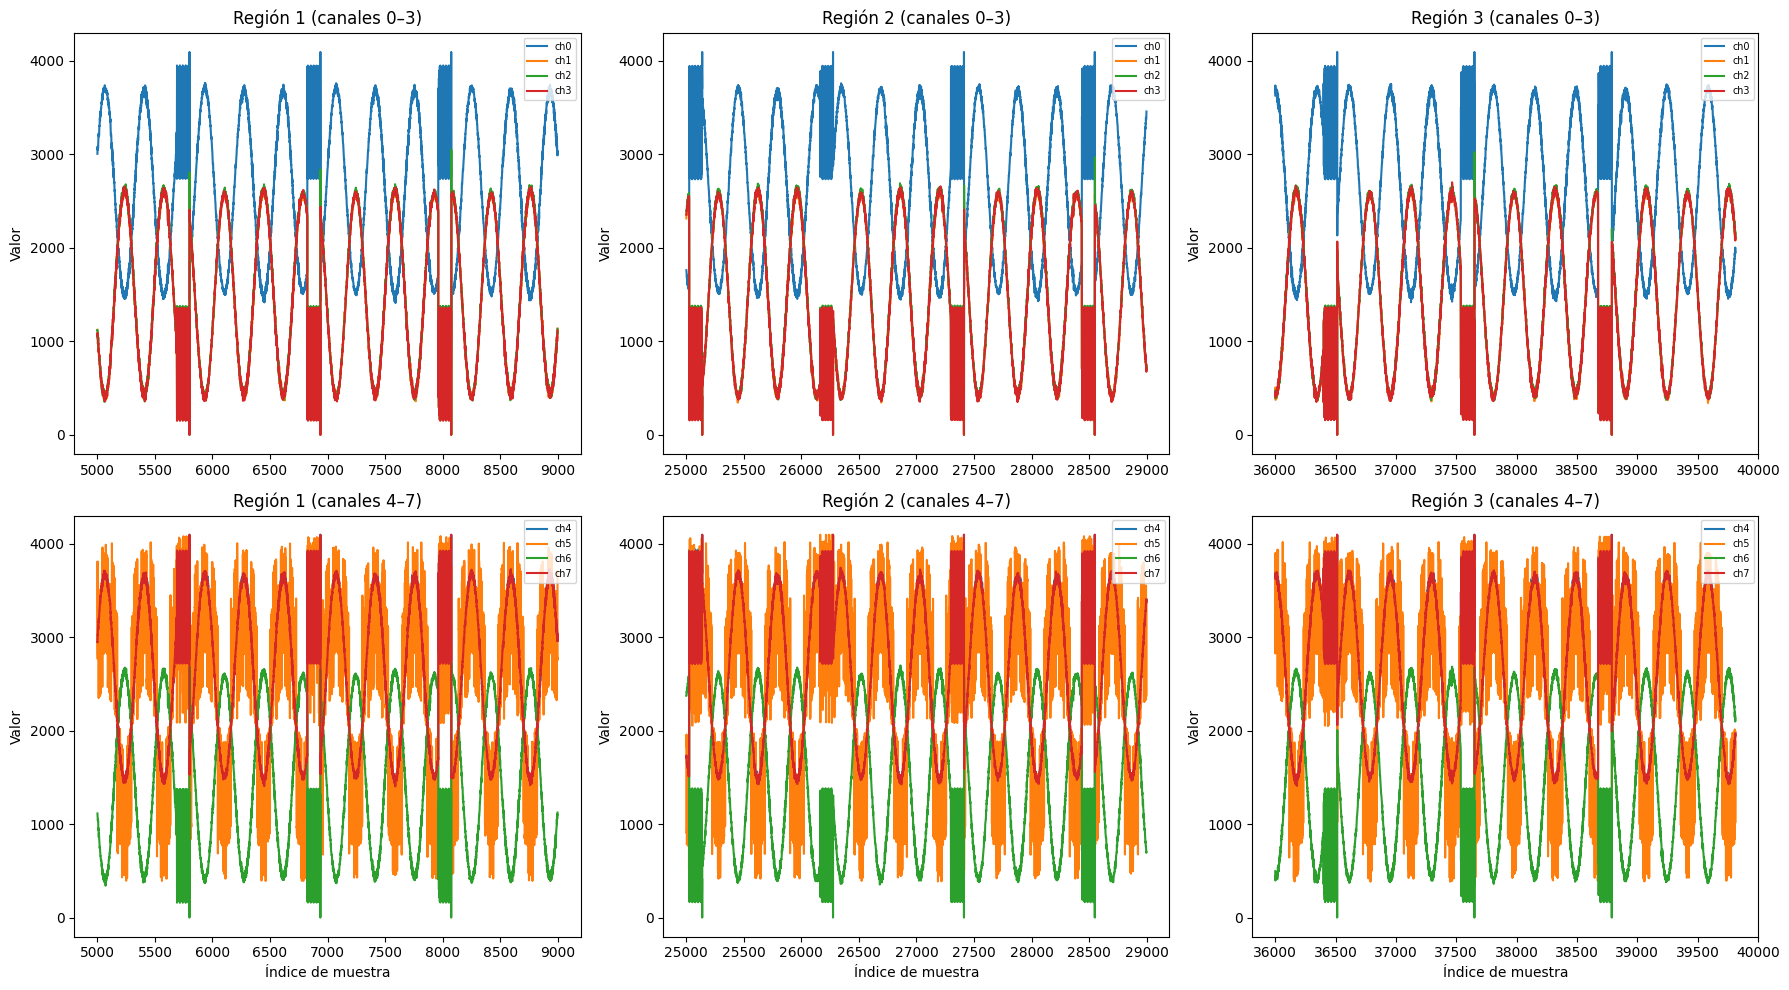

In [5]:
#   Plot de los distintos canales
#   utilizando distintos intervalos
#

# Parámetros generales
dataframe_use = df
start_points = [5_000, 25_000, 36_000]
epsilon = 4000
top_channels = range(4)
bot_channels = range(4, 8)


# --------------
# Figura 2x3
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for col, start in enumerate(start_points):
    df_slice = dataframe_use.iloc[start : start + epsilon]

    for row, channels in enumerate([top_channels, bot_channels]):
        ax = axes[row, col]

        for ch in channels:
            ax.plot(df_slice[f"ch{ch}"], label=f"ch{ch}")

        ax.set_title(f"Región {col+1} (canales {channels.start}–{channels.stop-1})")
        ax.set_xlabel("Índice de muestra") if row == 1 else None
        ax.set_ylabel("Valor")
        ax.legend(loc="upper right", fontsize="x-small")

        # Limitar número de ticks para claridad
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))
#        ax.yaxis.set_major_formatter(decimal_formatter)

plt.tight_layout()
plt.show()


## analisis de los time stamps

              t  count        dt
0  1.653564e+09     16       NaN
1  1.653564e+09     18  0.007921
2  1.653564e+09     19  0.007997
3  1.653564e+09     17  0.007992
4  1.653564e+09     18  0.007996
5  1.653564e+09     18  0.007993
6  1.653564e+09      4  0.007995
7  1.653564e+09      3  0.297279
8  1.653564e+09     17  0.008018
9  1.653564e+09     19  0.007979


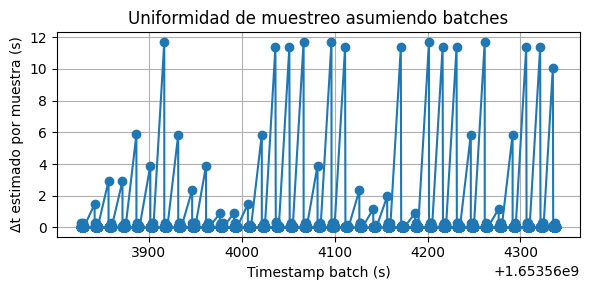

In [6]:
# Detectar batches: grupos de filas con mismo timestamp
groups = df.groupby("t").size().reset_index(name="count")
# Calcular dt entre batches sucesivos
groups["dt"] = groups["t"].diff()

print(groups.head(10))   # para ver tamaños de batch y dt

# Comprobar uniformidad de muestreo
# asumimos que el muestreo real ≈ dt_batch / count
groups["dt_per_sample"] = groups["dt"] / groups["count"]
plt.figure(figsize=(6,3))
plt.plot(groups["t"].iloc[1:], groups["dt_per_sample"].iloc[1:], marker='o', linestyle='-')
plt.xlabel("Timestamp batch (s)")
plt.ylabel("Δt estimado por muestra (s)")
plt.title("Uniformidad de muestreo asumiendo batches")
plt.grid(True)
plt.tight_layout()



### Regresión lineal

Los datos tienen un comportamiento fractal, al hacer zoom a ellos.

Una hipotesis es que esto es causado debido a los multiples buffers en el proceso, sampleo, distribución, comunicación, almacenamiento en memoria, etc...

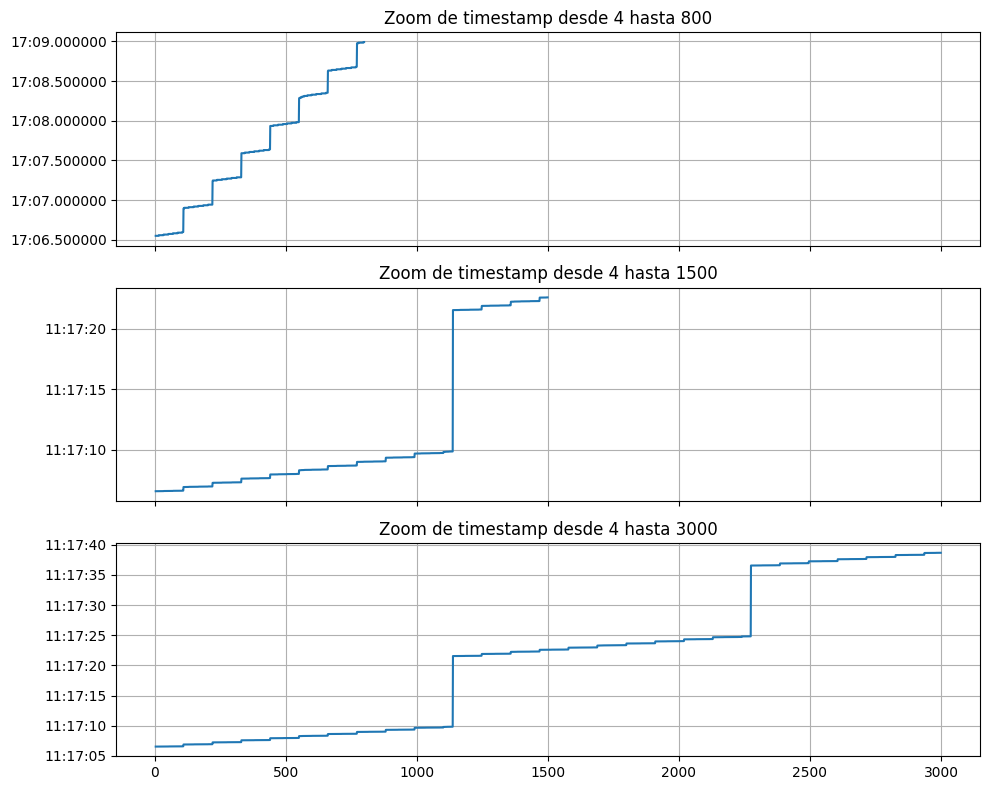

In [7]:
zoom_ranges = [(4, 800), (4, 1500), (4, 3000)]

# Crea subplots verticales
fig, axs = plt.subplots(len(zoom_ranges), 1, figsize=(10, 8), sharex=True)

# Recorremos cada rango y su subplot asociado
for ax, (start, end) in zip(axs, zoom_ranges):
    ax.plot(df['timestamp'].iloc[start:end])
    ax.set_title(f'Zoom de timestamp desde {start} hasta {end}')
    ax.grid(True)

# Ajustamos el layout para evitar solapamiento
plt.tight_layout()
plt.show()

In [8]:
df.head()

,t,id,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7,timestamp
0,1.653564e+09,800,3365,736,739,726,3362,2050,745,3341,2022-05-26 11:17:06.549341184
1,1.653564e+09,800,3365,736,739,726,3362,2050,745,3341,2022-05-26 11:17:06.549341184
2,1.653564e+09,801,3957,149,152,144,3948,2895,153,3931,2022-05-26 11:17:06.549341184
3,1.653564e+09,802,3406,698,712,702,3381,2431,710,3383,2022-05-26 11:17:06.549341184
4,1.653564e+09,803,2746,1353,1370,1354,2726,3041,1371,2724,2022-05-26 11:17:06.549341184


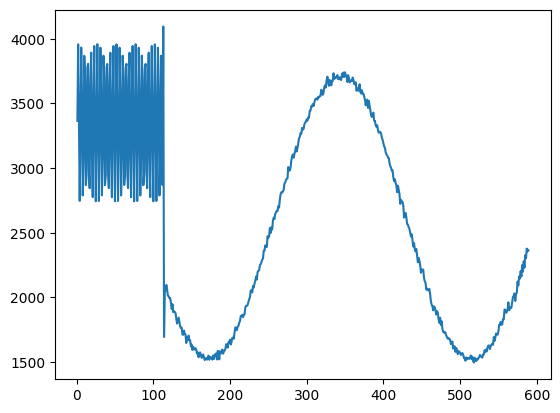

In [9]:
df_sample = df.iloc[1:590]
plt.plot(df_sample['ch0'])

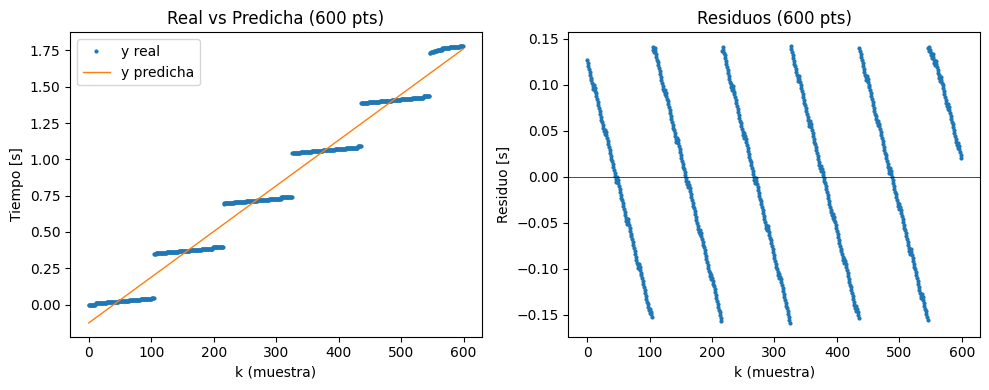

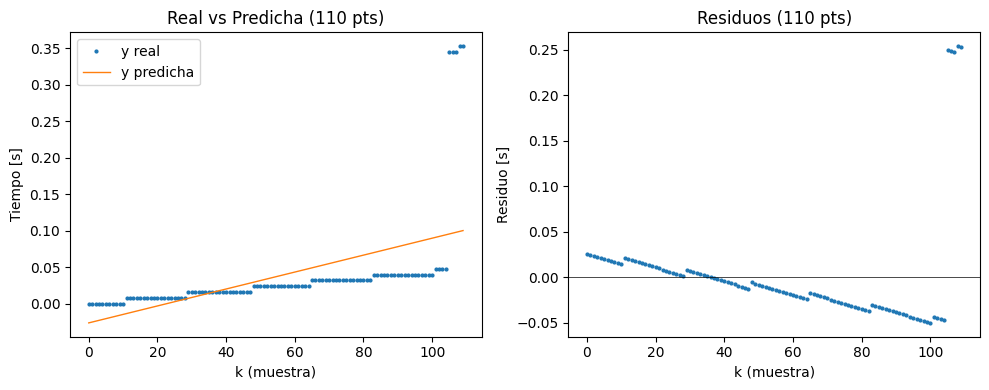

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Suponemos que df['timestamp'] ya está definido

# Prepara los datos
df = df.iloc[1:]
t0 = df['timestamp'].iloc[0]
y_all = (df['timestamp'] - t0).dt.total_seconds().values

def run_regression_with_subplots(n_points):
    start = 4
    end = start + n_points
    idx = np.arange(start, end)
    
    k = np.arange(n_points).reshape(-1,1)
    y = y_all[idx]
    
    # Ajuste de regresión
    model = LinearRegression()
    model.fit(k, y)
    y_pred = model.predict(k)
    
    # Cálculo de residuos
    residuals = y - y_pred
    
    # Crear figura con 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Primer subplot: y vs k y y_pred vs k
    ax1.plot(k, y, '.', markersize=4, label='y real')
    ax1.plot(k, y_pred, '-', linewidth=1, label='y predicha')
    ax1.set_title(f"Real vs Predicha ({n_points} pts)")
    ax1.set_xlabel("k (muestra)")
    ax1.set_ylabel("Tiempo [s]")
    ax1.legend()
    
    # Segundo subplot: residuos
    ax2.plot(k, residuals, '.', markersize=4)
    ax2.axhline(0, color='k', linewidth=0.5)
    ax2.set_title(f"Residuos ({n_points} pts)")
    ax2.set_xlabel("k (muestra)")
    ax2.set_ylabel("Residuo [s]")
    
    plt.tight_layout()
    plt.show()
    return model

# Ejecución para 100 y 1000 puntos
run_regression_with_subplots(600)
model = run_regression_with_subplots(110)


In [11]:
model.intercept_

-0.026216510018673235

In [12]:
model.coef_

array([0.00116118])

In [13]:
coef = 0.00129798
intercept = -0.030460957185257993

## Estimar el sampling rate de manera clasica
Utilizando promedios


In [14]:

groups = []
current_ts = df['timestamp'].iloc[1]
count = 1
for ts in df['timestamp'].iloc[1:]:
    if ts == current_ts:
        count += 1
    else:
        groups.append((current_ts, count))
        current_ts = ts
        count = 1
# Añadir último grupo
groups.append((current_ts, count))

# 4) Calcular Δt puntual por transición de grupo
#    Δt_i = (t_{i+1} - t_i) / n_{i+1}
dts = []
for (t_i, n_i), (t_j, n_j) in zip(groups[:-1], groups[1:]):
    delta = (t_j - t_i).total_seconds()
    print(delta, n_j)
    if n_j > 0:
        dts.append(delta / n_j)

dts = np.array(dts)

# 5) Filtrar outliers (IQR)
q1, q3 = np.percentile(dts, [25, 75])
iqr = q3 - q1
mask = (dts >= q1 - 1.5 * iqr) & (dts <= q3 + 1.5 * iqr)
dts_filtered = dts[mask]

# 6) Estimación final del período de muestreo
sampling_interval = np.median(dts_filtered)
print(f"Intervalo de muestreo ≃ {sampling_interval:.6f} segundos")

# 7) (Opcional) Seguimiento de convergencia
# Mantén un array de medianas acumuladas con más datos:
medianas_acum = [np.median(dts_filtered[:i]) for i in range(10, len(dts_filtered), 50)]


0.007921 18
0.007996 19
0.007992 17
0.007995 18
0.007993 18
0.007995 4
0.297279 3
0.008018 17
0.007979 19
0.007995 18
0.007994 19
0.007994 18
0.007994 17
0.2966 1
0.007804 16
0.007983 19
0.007997 18
0.007997 19
0.00799 19
0.007993 18
0.303814 13
0.007977 18
0.007992 18
0.007994 19
0.007994 18
0.007997 19
0.007996 5
0.295758 12
0.007994 18
0.007994 19
0.007995 15
0.008032 18
0.008 18
0.007951 10
0.298812 2
0.007664 5
0.007991 5
0.007994 8
0.007992 12
0.007993 16
0.007994 18
0.007994 19
0.007994 18
0.007994 7
0.272159 1
0.007668 14
0.008018 18
0.008001 19
0.007977 18
0.008016 19
0.007945 18
0.00804 4
0.295901 6
0.007889 19
0.007998 18
0.00799 19
0.007996 19
0.007994 18
0.007994 11
0.298806 9
0.007725 18
0.007993 19
0.007995 18
0.007998 19
0.00799 18
0.007993 9
0.296055 4
0.007742 19
0.007994 18
0.007995 19
0.007994 18
0.007994 19
0.007994 13
0.088236 3
0.007712 5
0.007994 5
0.007987 8
0.007986 12
0.007996 3
11.708007 8
0.007957 18
0.007992 19
0.007996 18
0.007995 19
0.007991 18
0.007997 

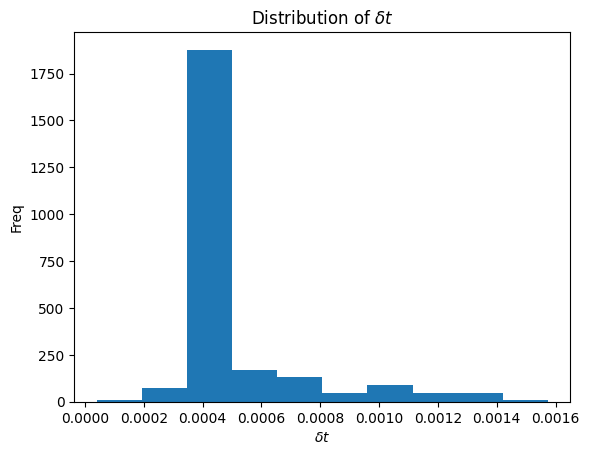

In [15]:
plt.hist(dts_filtered)
plt.title("Distribution of $\delta t$")
plt.ylabel('Freq')
plt.xlabel('$\delta t$')
plt.show()

estamos observanod una estimación, un valor mediano de separación entre los datos, sin embargo esto podría no significar un buen estimador del tiempo de muestro o sampling; en el caso en que tengamos un sampling en grupos no uniformes ni tiempos uniformes.

## Sampling a todos los ficheros

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import glob
import os
import pandas as pd
import numpy as np


In [17]:
def pre_pipeline(df):
    """
    Limpieza del dataframe y la aplicación de operaciones para dejar los datos en el formato más comodo
    """
    # Nans
    mask = df.isna().any(axis=1)
    indices = df.index[mask].tolist()

    df = df.fillna(method='bfill')

    # Aplicación de
    # Conversión del formato de datos
    df['timestamp'] = pd.to_datetime(df['t'], unit='s')

    def safe_hex_to_int(x):
        try:
            return int(x, 16)
        except (ValueError, TypeError):
            return float('nan')

    channel_cols = [col for col in df.columns if col.startswith('ch')]
    df[channel_cols] = df[channel_cols].applymap(safe_hex_to_int)
    return df

def import_file(data="../0_raw/verDAQ8_data_2022_05_26_131703_00000.dat", log_path="parse_errors.log"):
    try:
        df = pd.read_csv(
            data,
            delim_whitespace=True,
            comment='#',
            header=None,
            names=["t", "id"] + [f"ch{x}" for x in range(8)],
            on_bad_lines='error'  # Intentamos leer con control
        )
    except pd.errors.ParserError as e:
        # Extraer línea del error
        with open(log_path, 'a') as log:
            log.write(f"Error en archivo: {data}\n")
            log.write(f"{str(e)}\n\n")
        # Volvemos a intentar ignorando las líneas problemáticas
        df = pd.read_csv(
            data,
            delim_whitespace=True,
            comment='#',
            header=None,
            names=["t", "id"] + [f"ch{x}" for x in range(8)],
            on_bad_lines='skip'
        )

    df = pre_pipeline(df)
    return df




In [18]:
# Testing del pipeline de importar para visitar todos los verDAQ en la carpeta basica
# toma alrededor de 3 minutos en importar todos

files = glob.glob("../0_raw/ver*.dat")

records = []
for f in files:
    df = import_file(f)
    df.head()

In [19]:


# 1) Buscar todos los archivos .dat en la carpeta ../0_raw
files = glob.glob("../0_raw/ver*.dat")

records = []
for f in files:
    try:
    
        df = import_file(f)
        
        # existen batches o duplicados ene ste archivo?
        n_dups = df['timestamp'].duplicated().sum()
        print(f"Repetidos: {n_dups}/{len(df)}")

        # size de los grupos
        runs = df['timestamp'].diff().ne(pd.Timedelta(0)).cumsum()
        sizes = df.groupby(runs).size()
        print(sizes.value_counts().sort_index().to_dict())


        # 4) Agrupar contiguamente por timestamp igual
        ts = df['timestamp']
        groups = []
        current_ts = ts.iloc[0]
        count = 1
        for ts_i in ts.iloc[1:]:
            if ts_i == current_ts:
                count += 1
            else:
                groups.append((current_ts, count))
                current_ts = ts_i
                count = 1
        groups.append((current_ts, count))
        
        # 5) Calcular intervalos puntuales Δt_i
        deltas = []
        for (t_i, n_i), (t_j, n_j) in zip(groups[:-1], groups[1:]):
            delta = (t_j - t_i).total_seconds()
            #print(delta, n_j)
            if n_j > 0:
                deltas.append(delta / n_j)
        deltas = np.array(deltas)
        
        # 6) Filtrar outliers por IQR
        if deltas.size > 0:
            q1, q3 = np.percentile(deltas, [25, 75])
            iqr = q3 - q1
            mask = (deltas >= q1 - 1.5 * iqr) & (deltas <= q3 + 1.5 * iqr)
            filtered = deltas[mask]
            median = np.median(filtered)
            std = np.std(filtered, ddof=1)

            print(f, median, std)
        else:
            median = np.nan
            std = np.nan
        
        records.append({
            "file_name": os.path.basename(f),
            "sampling_median": median,
            "sampling_std": std
        })
    except Exception:
        records.append({
            "file_name": os.path.basename(f),
            "sampling_median": np.nan,
            "sampling_std": np.nan
        })

# 7) Crear dataframe de resultados
df_out = pd.DataFrame(records)
df_out.head()


Repetidos: 168226/179725
{1: 627, 2: 1192, 3: 564, 4: 193, 5: 192, 6: 192, 7: 192, 8: 194, 9: 198, 10: 186, 11: 197, 12: 197, 13: 208, 14: 180, 15: 173, 16: 198, 17: 182, 18: 191, 19: 178, 20: 190, 21: 190, 22: 345, 23: 3372, 24: 1968}
../0_raw\verDAQ8_data_2022_05_24_201646_00003.dat 0.0004347826086956522 0.00023067654348778096
Repetidos: 168144/179725
{1: 700, 2: 1248, 3: 514, 4: 150, 5: 169, 6: 194, 7: 190, 8: 194, 9: 240, 10: 193, 11: 182, 12: 195, 13: 187, 14: 157, 15: 172, 16: 165, 17: 161, 18: 168, 19: 144, 20: 160, 21: 168, 22: 775, 23: 4780, 24: 375}
../0_raw\verDAQ8_data_2022_05_24_235910_00011.dat 0.0004348260869565217 0.00023622147521605179
Repetidos: 13864134/14956356
{1: 72752, 2: 161541, 3: 66257, 4: 17462, 5: 18865, 6: 19210, 7: 19203, 8: 18009, 9: 21069, 10: 18790, 11: 17627, 12: 17397, 13: 17285, 14: 16233, 15: 16515, 16: 19291, 17: 28330, 18: 65019, 19: 47950, 20: 12183, 21: 14411, 22: 38214, 23: 301327, 24: 47279, 25: 2, 27: 1}
../0_raw\verDAQ8_data_2022_05_25-29_al

,file_name,sampling_median,sampling_std
0,verDAQ8_data_2022_05_24_201646_00003.dat,0.000435,0.000231
1,verDAQ8_data_2022_05_24_235910_00011.dat,0.000435,0.000236
2,verDAQ8_data_2022_05_25-29_all.dat,0.000440,0.000248
3,verDAQ8_data_2022_05_26_131703_00000.dat,0.000444,0.000210


In [20]:
df_out

,file_name,sampling_median,sampling_std
0,verDAQ8_data_2022_05_24_201646_00003.dat,0.000435,0.000231
1,verDAQ8_data_2022_05_24_235910_00011.dat,0.000435,0.000236
2,verDAQ8_data_2022_05_25-29_all.dat,0.000440,0.000248
3,verDAQ8_data_2022_05_26_131703_00000.dat,0.000444,0.000210


In [21]:
# coeficiente de variacion
df_out['C_var'] = df_out['sampling_std'] / df_out['sampling_median']
df_out

,file_name,sampling_median,sampling_std,C_var
0,verDAQ8_data_2022_05_24_201646_00003.dat,0.000435,0.000231,0.530556
1,verDAQ8_data_2022_05_24_235910_00011.dat,0.000435,0.000236,0.543255
2,verDAQ8_data_2022_05_25-29_all.dat,0.000440,0.000248,0.562250
3,verDAQ8_data_2022_05_26_131703_00000.dat,0.000444,0.000210,0.473397


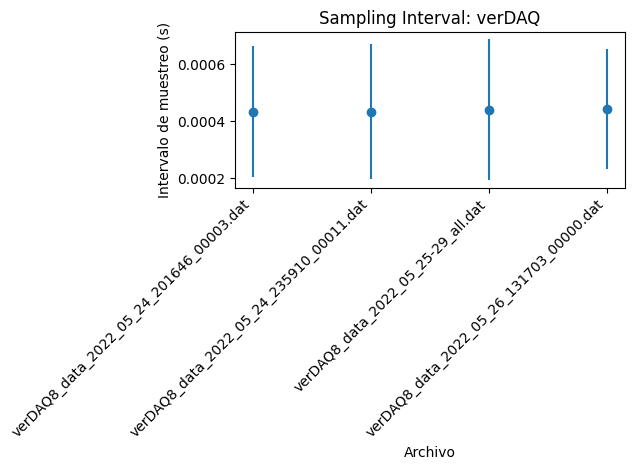

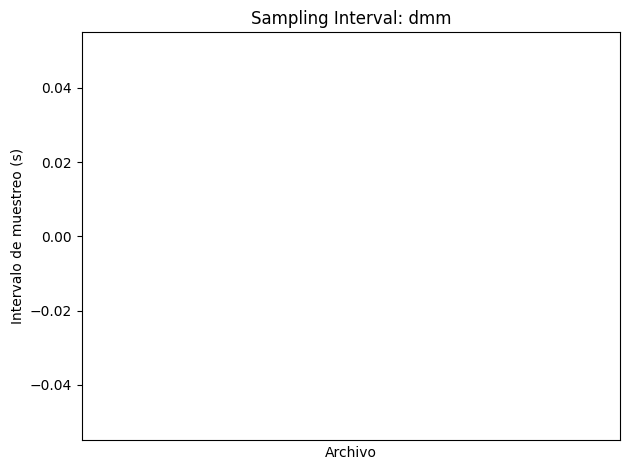

In [22]:

ver = df_out[df_out['file_name'].str.contains('verDAQ')]
dmm = df_out[df_out['file_name'].str.contains('dmm')]

# Gráfico para verDAQ
fig, ax = plt.subplots()
x_ver = range(len(ver))
ax.errorbar(x_ver, ver['sampling_median'], yerr=ver['sampling_std'], fmt='o')
ax.set_xticks(x_ver)
ax.set_xticklabels(ver['file_name'], rotation=45, ha='right')
ax.set_xlabel('Archivo')
ax.set_ylabel('Intervalo de muestreo (s)')
ax.set_title('Sampling Interval: verDAQ')
plt.tight_layout()

# Gráfico para dmm
fig, ax = plt.subplots()
x_dmm = range(len(dmm))
ax.errorbar(x_dmm, dmm['sampling_median'], yerr=dmm['sampling_std'], fmt='o')
ax.set_xticks(x_dmm)
ax.set_xticklabels(dmm['file_name'], rotation=45, ha='right')
ax.set_xlabel('Archivo')
ax.set_ylabel('Intervalo de muestreo (s)')
ax.set_title('Sampling Interval: dmm')
plt.tight_layout()

plt.show()


## Prueba del estimador

Calcularemos un estimador del tiempo de muestreo. Para ello se utiliza un metodo de ventanas que recorren los datos, siempre tomando entre saltos significativos.

Limitaciones:
un salto grande o significativo se calcula usando un rango intercuartil. El metodo puede fallar al ignorar o tener fuera del rango intercuartil el tiempo de muestreo verdadero.
Unicamente estamos incorporando todos los errores o jitters del tiempo de muestreo en un valor medio.

- Estamos entonces no solo midiendo información del verDAQ aislado, pero teniendo en cuenta todo el sistema de adquisición de datos, incluyendo el tag temporal en la computadora en el backend.


En caso de encontrar un tiempo de muestreo que describa bien al grupo de datos, se ha de observar una distribución uniforme alrededor del 0, en caso opuesto, tendríamos un drift acumulado, osea un reloj estimado que diverge del reloj subyacente a estudiar.



In [23]:
import glob
import os
import pandas as pd
import numpy as np

# 1) Cargar datos (ruta según tu sistema)
data_folder = "../0_raw/data"
#data_folder = "../0_raw/TCMS_RadTest/data_run/VERDAQ8_data"

# este log se veia bastante limpio
# daqlog_2022_05_27_161635
files = glob.glob(f"{data_folder}/verDAQ8_data_2022_05_*.dat")


records = []
for f in files:
    try:
        df = import_file(f)
        print(df.shape)
        # existen batches o duplicados en este archivo?
        n_dups = df['timestamp'].duplicated().sum()
        print(f"{os.path.basename(f)}: Duplicados: {n_dups}/{len(df)}")

        # tamaño de los grupos
        runs = df['timestamp'].diff().ne(pd.Timedelta(0)).cumsum()
        sizes = df.groupby(runs).size()
        print(f"{os.path.basename(f)}: tamaños batches: {sizes.value_counts().sort_index().to_dict()}")

        # 4) Agrupar contiguamente por timestamp igual
        ts = df['timestamp']
        groups = []
        current_ts = ts.iloc[0]
        count = 1
        for ts_i in ts.iloc[1:]:
            if ts_i == current_ts:
                count += 1
            else:
                groups.append((current_ts, count))
                current_ts = ts_i
                count = 1
        groups.append((current_ts, count))
        
        # 5) Calcular intervalos puntuales Δt_i (timestamp marca fin del lote)
        deltas = []
        for (t_i, n_i), (t_j, n_j) in zip(groups[:-1], groups[1:]):
            delta_total = (t_j - t_i).total_seconds()
            deltas.append(delta_total / n_j)
        deltas = np.array(deltas)

        # 6) Detectar jumps (valores atípicos grandes)
        q1, q3 = np.percentile(deltas, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        jump_idxs = np.where((deltas < lower_bound) | (deltas > upper_bound))[0]
        if jump_idxs.size > 0:
            print(f"  ⚠️ Encontrados {jump_idxs.size} jumps en indices: {jump_idxs[:5]}{'...' if jump_idxs.size>5 else ''}")
        else:
            print("  ✔️ No se detectaron jumps significativos.")

        # 7) Filtrar jumps y calcular estadísticos
        deltas_good = deltas[(deltas >= lower_bound) & (deltas <= upper_bound)]
        if deltas_good.size > 0:
            median = np.median(deltas_good)
            std = np.std(deltas_good, ddof=1) if deltas_good.size > 1 else 0.0
        else:
            median = np.nan
            std = np.nan

        records.append({
            "file_name": os.path.basename(f),
            "num_jumps": int(jump_idxs.size),
            "sampling_median": median,
            "sampling_std": std
        })

    except Exception as e:
        print(f"Error en {os.path.basename(f)}: {e}")
        records.append({
            "file_name": os.path.basename(f),
            "num_jumps": np.nan,
            "sampling_median": np.nan,
            "sampling_std": np.nan
        })

print(records)
# 8) Crear dataframe de resultados
df_out = pd.DataFrame(records)

df_out['C_var'] = df_out['sampling_std'] / df_out['sampling_median']
time_estimator = df_out
# utilizaremos el estimador de tiempo más adelante
time_estimator.head()


(179725, 11)
verDAQ8_data_2022_05_24_165008_00003.dat: Duplicados: 168985/179725
verDAQ8_data_2022_05_24_165008_00003.dat: tamaños batches: {1: 462, 2: 618, 3: 389, 4: 168, 5: 182, 6: 201, 7: 185, 8: 186, 9: 233, 10: 222, 11: 191, 12: 219, 13: 184, 14: 159, 15: 182, 16: 187, 17: 187, 18: 186, 19: 188, 20: 183, 21: 272, 22: 569, 23: 4574, 24: 613}
  ⚠️ Encontrados 2221 jumps en indices: [ 0  6 11 17 23]...
(179725, 11)
verDAQ8_data_2022_05_27_164735_00000.dat: Duplicados: 161617/179725
verDAQ8_data_2022_05_27_164735_00000.dat: tamaños batches: {1: 1719, 2: 3758, 3: 1589, 4: 458, 5: 488, 6: 263, 7: 256, 8: 313, 9: 353, 10: 265, 11: 269, 12: 283, 13: 244, 14: 257, 15: 273, 16: 345, 17: 738, 18: 4040, 19: 2196, 20: 1}
  ⚠️ Encontrados 2968 jumps en indices: [ 0  1  9 10 17]...
[{'file_name': 'verDAQ8_data_2022_05_24_165008_00003.dat', 'num_jumps': 2221, 'sampling_median': 0.0004348260869565217, 'sampling_std': 0.0002319403680575601}, {'file_name': 'verDAQ8_data_2022_05_27_164735_00000.dat'

,file_name,num_jumps,sampling_median,sampling_std,C_var
0,verDAQ8_data_2022_05_24_165008_00003.dat,2221,0.000435,0.000232,0.533410
1,verDAQ8_data_2022_05_27_164735_00000.dat,2968,0.000445,0.000218,0.489835


Ahora probemos la hipotesis, en caso de ser un sampling global, a tiempos largos veriamos $\delta T = \Delta T(t) - \Delta \hat T$ se mantendria en un intervalo y no crecera con el tiempo, esto quiere decir, que tendra una distribucion Gaussiana.

$\Delta T(t)$ es el muestreo subyacente del dispositivo, el cual tenemos la hipotesis de ser constante en el tiempo y cuyos cambios en timestamp solo sean debidos al etiquetado $\Delta T(t) \rightarrow \Delta T$

In [24]:
# 4 ms por interacion, version numpy (actual)
# 40ms por iteracion version pandas
def running_diff(dataframe, global_dt):
    timestamps = df['timestamp'].values.astype('datetime64[ns]')
    n = np.arange(len(timestamps))
    t0 = timestamps[0]

    predicted_timestamps = t0 + n * np.timedelta64(int(global_dt * 1e9), 'ns')
    running_dif = (predicted_timestamps - timestamps) / np.timedelta64(1, 's')  # en segundos

    return running_dif

Optimizado del codigo previo: 0.00043985748792270526
--- verDAQ8_data_2022_05_24_165008_00003.dat ---


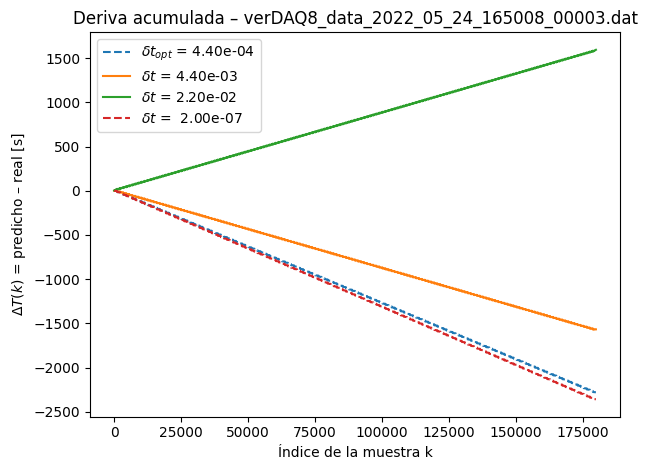

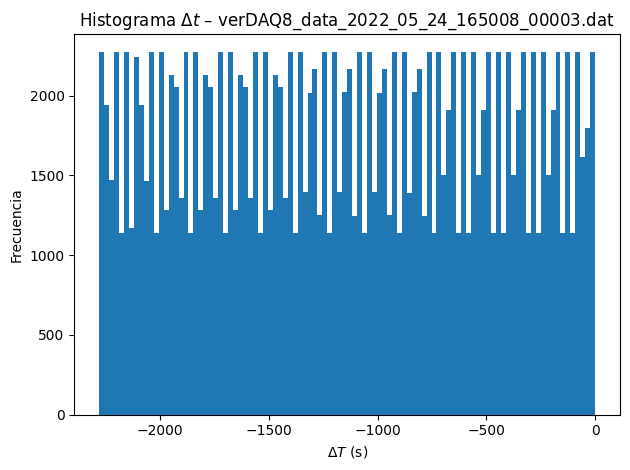

verDAQ8_data_2022_05_24_165008_00003.dat: skewness=-0.000, kurtosis=-1.200
--- verDAQ8_data_2022_05_27_164735_00000.dat ---


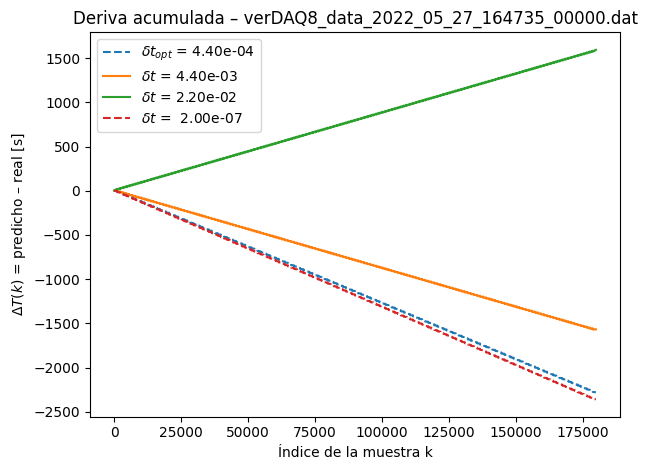

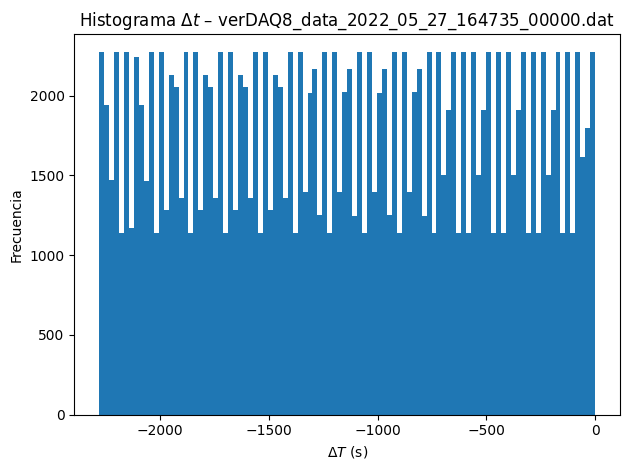

verDAQ8_data_2022_05_27_164735_00000.dat: skewness=-0.000, kurtosis=-1.200


In [25]:
# prueba la hipotesis si es algo gaussiano

import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# --- Cálculo del Δt promedio global ---
# aqui esta todo lo que calculamos previametne
global_dt = time_estimator['sampling_median'].mean()
print("Optimizado del codigo previo:", global_dt)

DeltaT_predicho = 2e-7
delta_Ts = [10, 50]


# --- Iterar sobre los archivos verDAQ ---
patron_archivos = "../0_raw/data/ver*.dat"

for fpath in glob.glob(patron_archivos):
    fname = os.path.basename(fpath)
    print("---" , fname, "---")
    # Carga de timestamps reales
    df = import_file(fpath)
    
    # ---- Timestamp predicho con el metodo ----
    # predigo un time stamp basado en  un global_dt
    df['running_dif'] = running_diff(df, global_dt)

    # =========================
    # 2nda prediccion:0i

    time_drift_2= running_diff(df, global_dt*delta_Ts[0])
    # =========================


    # =========================
    # tercera prediccion:0i
    time_drift_3 = running_diff(df, global_dt*delta_Ts[1])
    # =========================


    # =========================
    # cuarta prediccion: usando un delta externo
    
    time_drift_DT = running_diff(df, DeltaT_predicho)
    # =========================




    # 5) Gráfico de running_dif vs. índice


    plt.figure()
    #plt.xlim(0, 30_000)

    n = np.arange(len(df))

    plt.plot(n, df['running_dif'], '--', markersize=2, label=r'$\delta t_{opt}$'+f' = {global_dt:.2e}')
    plt.plot(n, time_drift_2, '-', markersize=2, label=rf'$\delta t`$ = {global_dt*delta_Ts[0]:.2e}')
    plt.plot(n, time_drift_3, '-', markersize=2, label=rf'$\delta t``$ = {global_dt*delta_Ts[1]:.2e}')
    plt.plot(n, time_drift_DT, '--', markersize=2, label=rf'$\delta t```$ =  {DeltaT_predicho:.2e}')
    
    plt.legend()
    plt.xlabel('Índice de la muestra k')
    plt.ylabel(r'$\Delta T(k)$ = predicho – real [s]')
    plt.title(f'Deriva acumulada – {fname}')
    plt.tight_layout()
        
    plt.show()



    # 6) Histograma de δt
    plt.figure()
    plt.hist(df['running_dif'].dropna(), bins=100)
    plt.xlabel(r'$\Delta T$ (s)')
    plt.ylabel('Frecuencia')
    plt.title(rf'Histograma $\Delta t$ – {fname}')
    plt.tight_layout()
    plt.show()

    # 7) Métricas de gaussianidad
    skewness = df['running_dif'].skew()
    kurtosis = df['running_dif'].kurtosis()
    print(f"{fname}: skewness={skewness:.3f}, kurtosis={kurtosis:.3f}")


In [26]:
def calculo_drift_rate(timestamps, running_dif):
    # Asumimos que timestamps son datetime64[ns] y running_dif es un array de float64
    dt_start = running_dif[0]
    dt_end = running_dif[-1]
    real_seconds = (timestamps[-1] - timestamps[0]) / np.timedelta64(1, 's')
    drift_rate = (dt_end - dt_start) / (real_seconds / 86400)  # s perdidos por día
    return drift_rate

def pipeline_drift_rate(df, global_dt):
    timestamps = df['timestamp'].values.astype('datetime64[ns]')
    n = np.arange(len(timestamps))
    t0 = timestamps[0]
    
    predicted_timestamps = t0 + n * np.timedelta64(int(global_dt * 1e9), 'ns')
    running_dif = (predicted_timestamps - timestamps) / np.timedelta64(1, 's')  # en segundos

    return calculo_drift_rate(timestamps, running_dif)


In [27]:
%%timeit
pipeline_drift_rate(df, global_dt)

5.75 ms ± 265 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


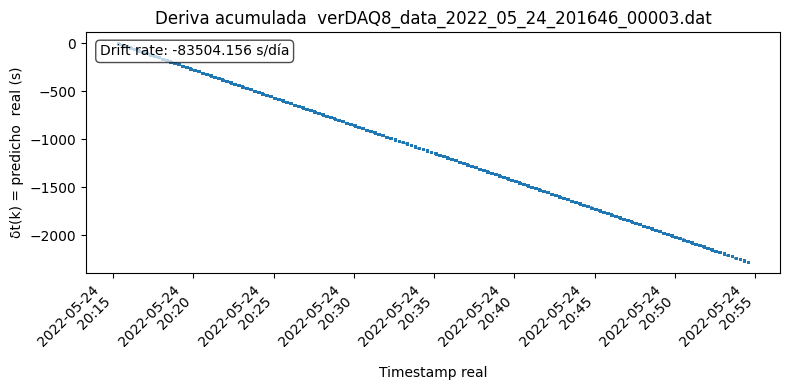

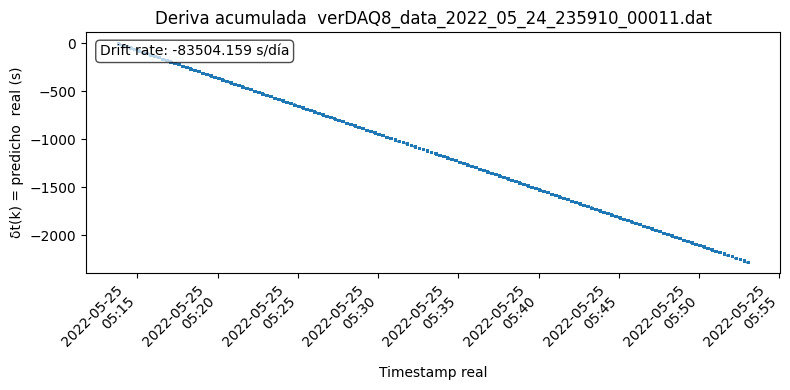

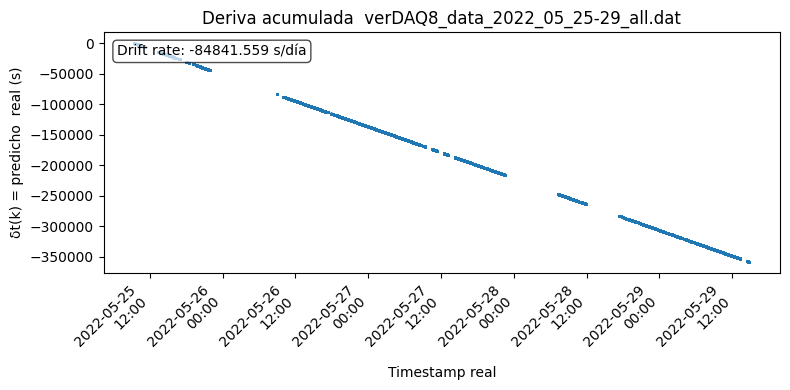

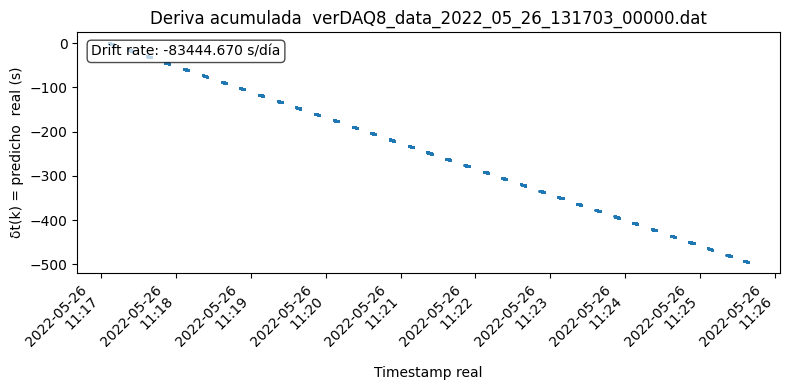

In [28]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Asumimos que df_out ya existe y contiene 'sampling_median'
global_dt = df_out['sampling_median'].mean()

for fpath in glob.glob("../0_raw/ver*.dat"):
    fname = os.path.basename(fpath)
    # --- Carga y cálculo de running_dif como antes ---
    df = pd.read_csv(
        fpath,
        delim_whitespace=True,
        comment='#',
        header=None,
        usecols=[0],
        names=['t']
    )
    df['timestamp'] = pd.to_datetime(df['t'], unit='s', errors='coerce')
    #df = df.dropna(subset=['timestamp']).reset_index(drop=True)
    df = df.fillna(method='bfill')

    predT_simT = running_diff(df, global_dt) # diferencia de timestamps
    drift_rate = pipeline_drift_rate(df, global_dt)

    # --- Gráfico: running_dif vs timestamp real ---
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(df['timestamp'], predT_simT, '.', markersize=2)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Timestamp real')
    plt.ylabel('δt(k) = predicho  real (s)')
    plt.title(f'Deriva acumulada  {fname}')
    # Anotación del ritmo
    text = f'Drift rate: {drift_rate:.3f} s/día'
    ax.text(0.02, 0.95, text, transform=ax.transAxes,
            fontsize=10, va='top', ha='left',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    plt.tight_layout()
    plt.show()


## Aprender $\Delta \hat T$

1. **`predict_timestamps(df, dt)`**: genera la serie de timestamps predichos $t_0 + k\,dt$.
2. **`compute_squared_error(df, dt)`**: calcula el error medio cuadrático entre los timestamps predichos y los reales.
3. **`optimize_dt_gradient_descent(df, dt_init, lr, n_iter)`**: aplica descenso de gradiente para minimizar el MSE y ajustar $\Delta t$.

En el bloque comentado al final puedes ver un ejemplo de uso: arrancando de un $\Delta t$ inicial (p.ej. la media de medianas) y obteniendo un nuevo valor optimizado junto con su MSE. Con esto tendrás un algoritmo iterativo para refinar tu estimación de muestreo.


---

$$
x= \Delta \hat T 
$$


$$
f = MSE = \sum_k (x * k - y)
$$

$$
\frac{\partial f}{\partial x}
$$

```python
error = (dt * k - y)**2
mse = np.sum(error)
mse
# gradiente dL/d(dt) = (2/N) * sum(error * k)
grad = np.sum(2*dt * k**2)

dt -= lr * grad
```

In [29]:
import numpy as np
import pandas as pd

def predict_timestamps(df: pd.DataFrame, dt: float) -> pd.Series:
    """
    Genera una serie de timestamps predichos.

    Args:
        df: DataFrame que contiene la columna 'timestamp' de tipo datetime64[ns].
        dt: Paso de muestreo estimado en segundos (float).

    Returns:
        pd.Series con los timestamps predichos:
        t0 + k * dt, para k = 0,1,...,len(df)-1.
    """
    t0 = df['timestamp'].iloc[0]
    k = np.arange(len(df))
    return t0 + pd.to_timedelta(k * dt, unit='s')

def compute_squared_error(df: pd.DataFrame, dt: float) -> float:
    """
    Calcula el error medio cuadrático entre timestamps reales y predichos.

    Args:
        df: DataFrame con columna 'timestamp' (datetime64[ns]).
        dt: Paso de muestreo estimado en segundos.

    Returns:
        mse: Error cuadrático medio (float) en unidades de segundos^2.
    """
    pred = predict_timestamps(df, dt)
    dif = (pred - df['timestamp']).dt.total_seconds()
    return np.mean(dif**2)

def optimize_dt_gradient_descent(df: pd.DataFrame,
                                 dt_init: float,
                                 lr: float = 1e-8,
                                 n_iter: int = 1000) -> float:
    """
    Ajusta dt para minimizar el MSE usando descenso de gradiente.

    El MSE como función de dt es:
        L(dt) = (1/N) ∑(k*dt - y_k)^2
    donde y_k = (t_real_k - t0)/s, k el índice de muestra.

    Args:
        df: DataFrame con columna 'timestamp' (datetime64[ns]).
        dt_init: Valor inicial de dt en segundos.
        lr: Learning rate (float), paso de actualización.
        n_iter: Número de iteraciones de descenso de gradiente.

    Returns:
        dt_opt: Valor optimizado de dt tras n_iter iteraciones.
    """
    # Preparar datos
    t0 = df['timestamp'].iloc[0]
    k = np.arange(len(df))/1e5
    y = (df['timestamp'] - t0).dt.total_seconds().values
    N = len(df)
    dt = dt_init

    # Descenso de gradiente
    for i in range(n_iter):
        # error_k = dt*k - y_k
        error = (dt * k - y)**2
        mse = np.sum(error)
        mse
        # gradiente dL/d(dt) = (2/N) * sum(error * k)
        grad = np.sum(2*dt * k**2)
        
        dt -= lr * grad

        if i%100 == 0:
            print(i, f"\tdt ={dt:.2e}", f"grad ={grad:.2e}", f'mse={mse:.2e}')

    return dt

dt0 = df_out['sampling_median'].mean()
mse0 = compute_squared_error(df, dt0)
dt_opt = optimize_dt_gradient_descent(df, dt_init=dt0, lr=1e-4, n_iter=10000)
mse_opt = compute_squared_error(df, dt_opt)
print(f"Inicial dt={dt0:.6f}s, MSE={mse0:.6e}")
print(f"Optimizado dt={dt_opt:.6f}s, MSE={mse_opt:.6e}")



0 	dt =2.55e-04 grad =1.85e+00 mse=3.53e+09
100 	dt =4.98e-28 grad =3.61e-24 mse=3.53e+09
200 	dt =9.72e-52 grad =7.06e-48 mse=3.53e+09
300 	dt =1.90e-75 grad =1.38e-71 mse=3.53e+09
400 	dt =3.71e-99 grad =2.69e-95 mse=3.53e+09
500 	dt =7.24e-123 grad =5.26e-119 mse=3.53e+09
600 	dt =1.41e-146 grad =1.03e-142 mse=3.53e+09
700 	dt =2.76e-170 grad =2.01e-166 mse=3.53e+09
800 	dt =5.40e-194 grad =3.92e-190 mse=3.53e+09
900 	dt =1.05e-217 grad =7.66e-214 mse=3.53e+09
1000 	dt =2.06e-241 grad =1.50e-237 mse=3.53e+09
1100 	dt =4.02e-265 grad =2.92e-261 mse=3.53e+09
1200 	dt =7.86e-289 grad =5.70e-285 mse=3.53e+09
1300 	dt =1.53e-312 grad =1.11e-308 mse=3.53e+09
1400 	dt =9.88e-324 grad =2.20e-320 mse=3.53e+09
1500 	dt =9.88e-324 grad =2.20e-320 mse=3.53e+09
1600 	dt =9.88e-324 grad =2.20e-320 mse=3.53e+09
1700 	dt =9.88e-324 grad =2.20e-320 mse=3.53e+09
1800 	dt =9.88e-324 grad =2.20e-320 mse=3.53e+09
1900 	dt =9.88e-324 grad =2.20e-320 mse=3.53e+09
2000 	dt =9.88e-324 grad =2.20e-320 mse=3.

In [30]:
import numpy as np

def optimize_dt_gradient_descent(df, dt_init, lr=1e-9, n_iter=5000):
    """
    Ajusta dt minimizando el MSE mediante descenso de gradiente.

    Args:
        df: DataFrame con columna 'timestamp' (datetime64[ns]).
        dt_init: valor inicial de Delta T (s).
        lr: learning rate.
        n_iter: número de iteraciones.

    Returns:
        dt: Delta T optimizado (s).
    """
    # 1) Datos relativos
    t0 = df['timestamp'].iloc[0]
    y = (df['timestamp'] - t0).dt.total_seconds().values
    k = np.arange(len(y))
    N = len(y)
    dt = dt_init

    # 2) Descenso de gradiente
    for i in range(n_iter):
        e = dt * k - y  # vector de errores
        
        # 2.1) Calcula el MSE (o SSE si prefieres)
        mse = np.mean(e**2)      # media de los cuadrados (MSE)
        # sse = np.sum(e**2)      # si prefieres suma de cuadrados

        # 2.2) Gradiente correcto
        grad = (2.0 / N) * np.dot(e, k)

        # 2.3) Actualiza dt
        dt -= lr * grad

        # 2.4) Logging cada 500 iteraciones
        if i % 500 == 0:
            print(f"it={i:4d} | dt={dt:.6e} s | grad={grad:.6e} | MSE={mse:.6e}")

    return dt

# Ejemplo de uso:
dt0  = df_out['sampling_median'].mean()
mse0 = compute_squared_error(df, dt0)
dt_opt = optimize_dt_gradient_descent(df, dt_init=dt0, lr=1e-12, n_iter=10000)
mse1 = compute_squared_error(df, dt_opt)

print(f"\nInicial : dt={dt0:.6e} s, MSE={mse0:.6e}")
print(f"Optimizado: dt={dt_opt:.6e} s, MSE={mse1:.6e}")


it=   0 | dt=4.530883e-04 s | grad=-1.323084e+07 | MSE=8.285175e+04
it= 500 | dt=5.588613e-03 s | grad=-7.798510e+06 | MSE=2.879626e+04
it=1000 | dt=8.615589e-03 s | grad=-4.596591e+06 | MSE=1.001658e+04
it=1500 | dt=1.039975e-02 s | grad=-2.709319e+06 | MSE=3.492240e+03
it=2000 | dt=1.145136e-02 s | grad=-1.596924e+06 | MSE=1.225586e+03
it=2500 | dt=1.207121e-02 s | grad=-9.412577e+05 | MSE=4.381170e+02
it=3000 | dt=1.243655e-02 s | grad=-5.547953e+05 | MSE=1.645384e+02
it=3500 | dt=1.265190e-02 s | grad=-3.270070e+05 | MSE=6.949315e+01
it=4000 | dt=1.277882e-02 s | grad=-1.927442e+05 | MSE=3.647301e+01
it=4500 | dt=1.285364e-02 s | grad=-1.136071e+05 | MSE=2.500132e+01
it=5000 | dt=1.289773e-02 s | grad=-6.696219e+04 | MSE=2.101589e+01
it=5500 | dt=1.292372e-02 s | grad=-3.946880e+04 | MSE=1.963129e+01
it=6000 | dt=1.293904e-02 s | grad=-2.326366e+04 | MSE=1.915025e+01
it=6500 | dt=1.294807e-02 s | grad=-1.371205e+04 | MSE=1.898314e+01
it=7000 | dt=1.295340e-02 s | grad=-8.082144e+03

## Aprender versión 2: 0527
Una versión mejorada de aprendizaje

### Estimación del $\delta t$ óptimo

Los timestamps reales vienen agrupados o con jitter debido a cómo se almacenan o transmiten. Para modelar un reloj ideal con paso constante (`ΔT`), comparamos los timestamps predichos con los reales:

$$
\Delta T_k = T_{\text{predicho}, k} - T_{\text{real}, k}
$$

Y calculamos la deriva acumulada por día como:

$$
\text{drift\_rate} = \frac{\Delta T_{\text{final}} - \Delta T_{\text{inicio}}}{\text{duración en días}}
$$

Queremos encontrar el `ΔT` que minimiza esta deriva:

$$
\min_{\delta t} \left| \text{drift\_rate}(\delta t) \right|
$$

La optimización se hace con el método de Brent (`scipy.optimize.minimize_scalar`), que es robusto y no requiere derivadas.

El resultado nos da el paso de muestreo que mejor ajusta un reloj ideal a la señal registrada.



In [36]:
import numpy as np
from scipy.optimize import minimize_scalar

def drift_rate_loss(delta_t, timestamps):
    n = np.arange(len(timestamps))
    t0 = timestamps[0]
    predicted = t0 + n * np.timedelta64(int(delta_t * 1e9), 'ns')
    running_dif = (predicted - timestamps) / np.timedelta64(1, 's')
    drift = calculo_drift_rate(timestamps, running_dif)
    return abs(drift)  # Queremos minimizar el valor absoluto de la deriva

def find_optimal_delta_t(df, guess=1e-3):
    timestamps = df['timestamp'].values.astype('datetime64[ns]')
    
    result = minimize_scalar(
        drift_rate_loss,
        args=(timestamps,),
        method='brent',
        bracket=(guess / 10, guess * 10),
        options={'xtol': 1e-10}
    )

    if result.success:
        return result.x
    else:
        raise RuntimeError("Optimización fallida: " + result.message)


In [39]:
optimal_dt = find_optimal_delta_t(df, guess=0.013)
print(f"Delta t óptimo encontrado: {optimal_dt:.8f} s")

drift_rate = pipeline_drift_rate(df, optimal_dt)
print(drift_rate)

Delta t óptimo encontrado: 0.01312351 s
-0.003173627887225639


Optimizado del codigo previo: 0.00043985748792270526
--- verDAQ8_data_2022_05_24_165008_00003.dat ---


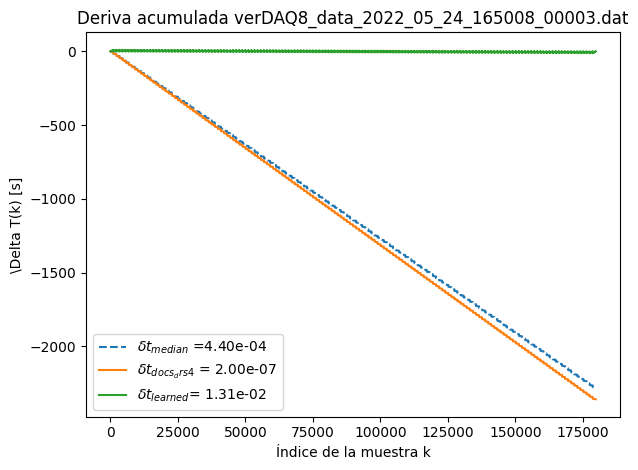

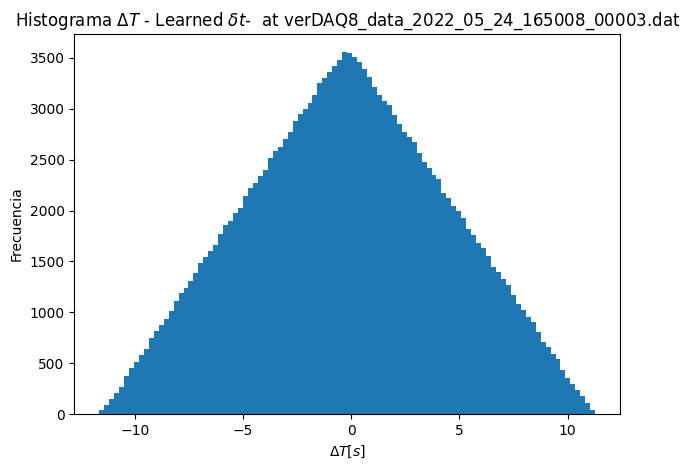

verDAQ8_data_2022_05_24_165008_00003.dat: skewness=0.002, kurtosis=-0.595
--- verDAQ8_data_2022_05_27_164735_00000.dat ---


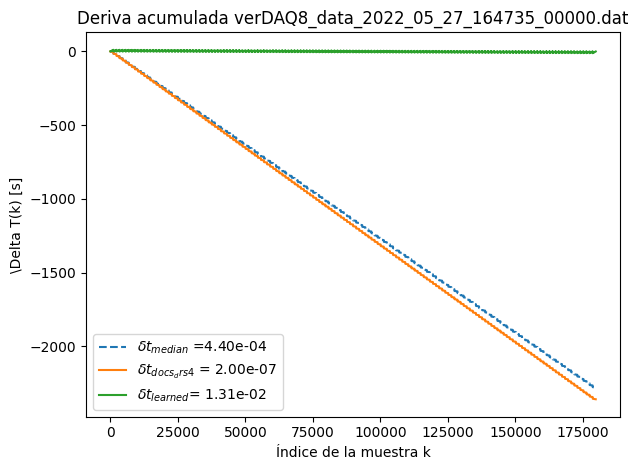

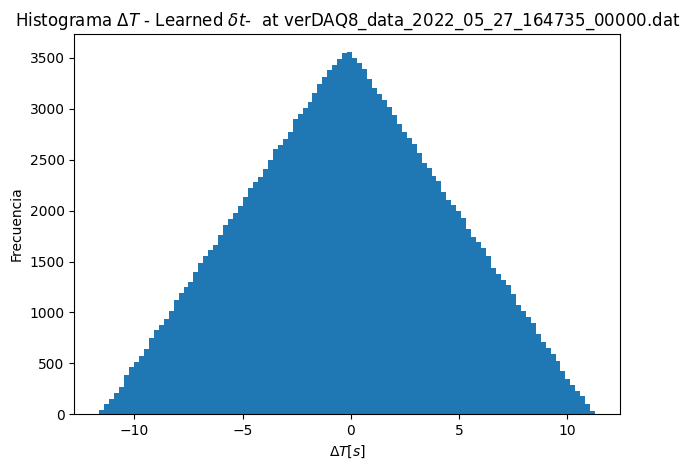

verDAQ8_data_2022_05_27_164735_00000.dat: skewness=0.001, kurtosis=-0.595


In [40]:
# prueba la hipotesis si es algo gaussiano

import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# --- Cálculo del Δt promedio global ---
# aqui esta todo lo que calculamos previametne
global_dt = time_estimator['sampling_median'].mean()
print("Optimizado del codigo previo:", global_dt)

DeltaT_predicho = 2e-7
# global_dt es el valor obtenido a partir 
delta_Ts = [global_dt, DeltaT_predicho, optimal_dt]


# --- Iterar sobre los archivos verDAQ ---
patron_archivos = "../0_raw/data/ver*.dat"

for fpath in glob.glob(patron_archivos):
    fname = os.path.basename(fpath)
    print("---" , fname, "---")
    # Carga de timestamps reales
    df = import_file(fpath)
    n = np.arange(len(df))

    # ---- Timestamp predicho con el metodo ----
    # predigo un time stamp basado en  un global_dt
    time_drift_median = running_diff(df, delta_Ts[0])

    time_drift_predicted_by_docs = running_diff(df, delta_Ts[1])

    time_drift_learned = running_diff(df, delta_Ts[2])

    # =========================




    # 5) Gráfico de running_dif vs. índice


    plt.figure()
    #plt.xlim(0, 30_000)
    plt.plot(n, time_drift_median, '--', markersize=2, label=r'$\delta t_{{median}}$ ='+f'{delta_Ts[0]:.2e}')
    plt.plot(n, time_drift_predicted_by_docs, '-', markersize=2, label=r'$\delta t_{{docs_drs4}}$ ='+f' {delta_Ts[1]:.2e}')
    plt.plot(n, time_drift_learned, '-', markersize=2, label=r'$\delta t_{{learned}}$'+f'= {delta_Ts[2]:.2e}')
    
    plt.legend()
    plt.xlabel('Índice de la muestra k')
    plt.ylabel(r'\Delta T(k) [s]')
    plt.title(f'Deriva acumulada {fname}')
    plt.tight_layout()
        
    plt.show()



    # 6) Histograma de δt

    df['running_dif'] = time_drift_learned

    plt.figure()
    plt.hist(df['running_dif'].dropna(), bins=100)
    plt.xlabel(r'$\Delta T [s]$')
    plt.ylabel('Frecuencia')
    plt.title(rf'Histograma $\Delta T$ - Learned $\delta t$-  at {fname}')
    plt.tight_layout()
    plt.show()

    # 7) Métricas de gaussianidad
    skewness = df['running_dif'].skew()
    kurtosis = df['running_dif'].kurtosis()
    print(f"{fname}: skewness={skewness:.3f}, kurtosis={kurtosis:.3f}")




In [ ]:
optimal_dt

0.013123511994454289

Legacy code:

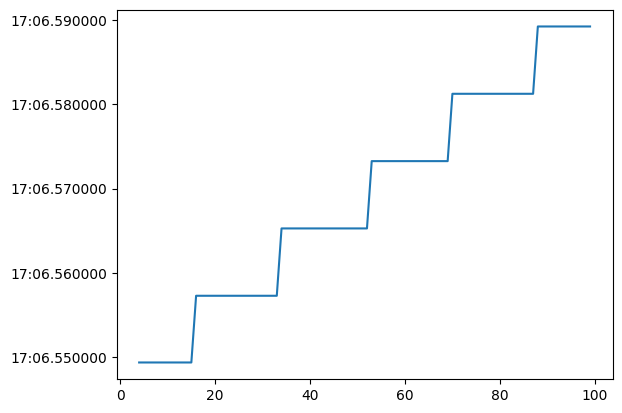

In [ ]:
plt.plot(df['timestamp'].iloc[4:100])

it=   0 | dt=4.375187e-04 s | grad=-2.736067e+08 | MSE=1.738225e+06


/tmp/ipykernel_1049/1654370943.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


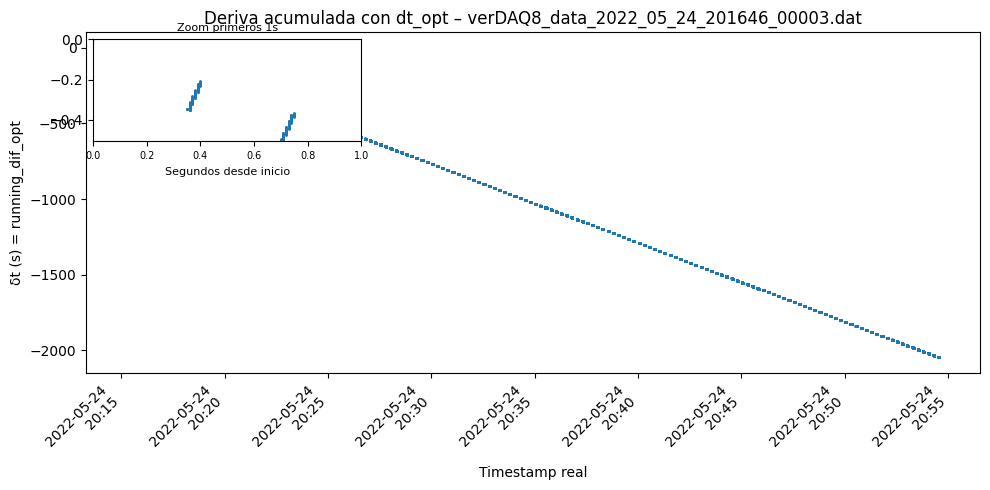

it=   0 | dt=4.375621e-04 s | grad=-2.736046e+08 | MSE=1.738198e+06


/tmp/ipykernel_1049/1654370943.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


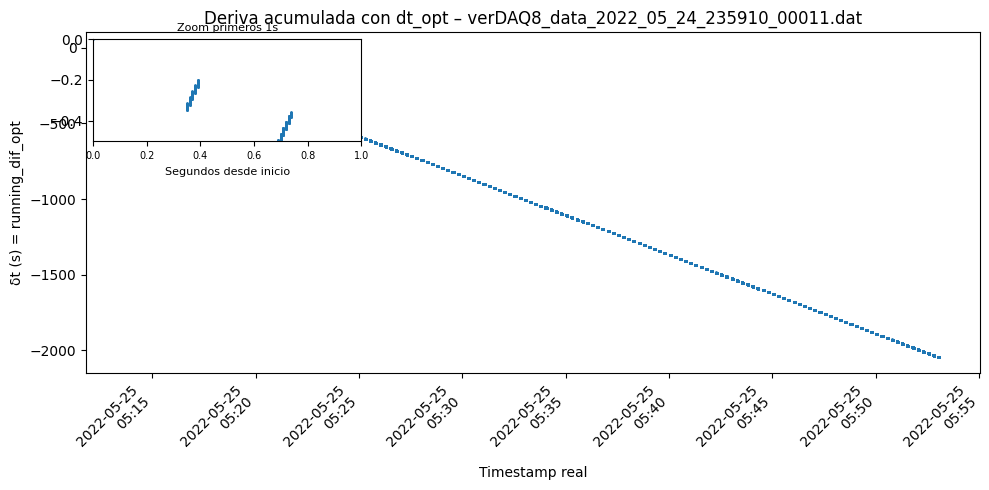

it=   0 | dt=3.752106e-02 s | grad=-3.708056e+12 | MSE=4.626440e+10


KeyboardInterrupt: 

In [ ]:
def plot_with_inset_zoom_seconds(df, drift_col, fname, zoom_seconds=3600):
    """
    Grafica la deriva con un inset zoom de los primeros `zoom_seconds` en el eje X en segundos.

    Args:
        df: DataFrame con columnas 'timestamp' (datetime) y drift_col (float).
        drift_col: nombre de la columna de deriva.
        fname: para el título.
        zoom_seconds: número de segundos a mostrar en el inset (default 3600).
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    # Prepara elapsed seconds
    t0 = df['timestamp'].iloc[0]
    elapsed = (df['timestamp'] - t0).dt.total_seconds().values
    df = df.copy()
    df['elapsed'] = elapsed

    # Gráfico principal (fechas)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df['timestamp'], df[drift_col], '.', markersize=2)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    plt.xticks(rotation=45, ha='right')
    ax.set_xlabel('Timestamp real')
    ax.set_ylabel(f'δt (s) = {drift_col}')
    ax.set_title(f'Deriva acumulada con dt_opt – {fname}')

    # Drift rate
    dt_start = df[drift_col].iloc[0]
    dt_end   = df[drift_col].iloc[-1]
    real_sec = elapsed[-1]
    drift_rate = (dt_end - dt_start) / (real_sec / 86400)
    ax.text(0.02, 0.95, f'Drift rate: {drift_rate:.3f} s/día',
            transform=ax.transAxes, fontsize=10, va='top', ha='left',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

    # Inset zoom (eje en segundos)
    axins = inset_axes(ax, width="30%", height="30%", loc='upper left')
    mask = df['elapsed'] <= zoom_seconds
    axins.plot(df.loc[mask, 'elapsed'], df.loc[mask, drift_col], '.', markersize=2)
    axins.set_xlim(0, zoom_seconds)
    ymin, ymax = df.loc[mask, drift_col].min(), df.loc[mask, drift_col].max()
    axins.set_ylim(ymin, ymax)
    axins.set_xlabel('Segundos desde inicio', fontsize=8)
    axins.tick_params(axis='x', labelsize=7)
    axins.set_title(f'Zoom primeros {zoom_seconds}s', fontsize=8)

    plt.tight_layout()
    plt.show()

# Loop principal
for fpath in glob.glob("../0_raw/ver*.dat"):
    fname = os.path.basename(fpath)
    # Cargas previas y cálculo de running_dif_opt...
    df = pd.read_csv(fpath, delim_whitespace=True, comment='#', header=None,
                     usecols=[0], names=['t'])
    df['timestamp'] = pd.to_datetime(df['t'], unit='s', errors='coerce')
    df = df.dropna(subset=['timestamp']).reset_index(drop=True)

    # Obtener dt_opt según tu función de optimización
    dt_init = df_out.set_index('file_name').loc[fname, 'sampling_median']
    dt_opt = optimize_dt_gradient_descent(df, dt_init, lr=1e-14, n_iter=500)

    # Calcular running_dif_opt
    k = np.arange(len(df))
    t0 = df['timestamp'].iloc[0]
    df['predicted_opt'] = t0 + pd.to_timedelta(k * dt_opt, unit='s')
    df['running_dif_opt'] = (df['predicted_opt'] - df['timestamp']).dt.total_seconds()

    # Graficar con inset zoom
    plot_with_inset_zoom_seconds(df, 'running_dif_opt', fname, zoom_seconds=1)


In [ ]:
dt_opt

9.462570676735589e-23

/tmp/ipykernel_1049/1771628473.py:65: RuntimeWarning: invalid value encountered in multiply
  error = dt * k - y


Inicial dt=0.000439s, MSE=8.286935e+04
Optimizado dt=nans, MSE=nan


## Prueba de muestrar pequeñas

In [ ]:
# mask para elegir el row correspondiente al archivo
mask = (time_estimator['file_name'] == f[9:])
idxs = time_estimator.index[mask]
idx = idxs.values[0] # elegimos el valor
# tenemos asi $\Delta \hat T$
Delta_T_estimated = time_estimator['sampling_median'][idx]



0.00044400000000000006

In [ ]:
time_estimator.iloc[idxs]

,file_name,num_jumps,sampling_median,sampling_std,C_var,global_median,delta_t
3,verDAQ8_data_2022_05_26_131703_00000.dat,544,0.000444,0.00021,0.473397,0.000439,0.000005


In [ ]:
time_estimator[(time_estimator['file_name'] == f)]["sampling_median"]

Series([], Name: sampling_median, dtype: float64)

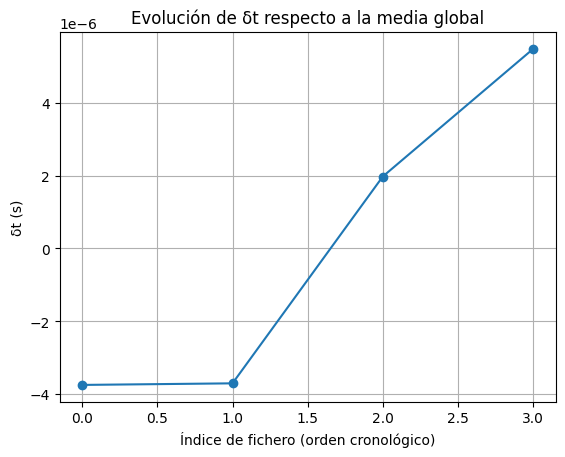

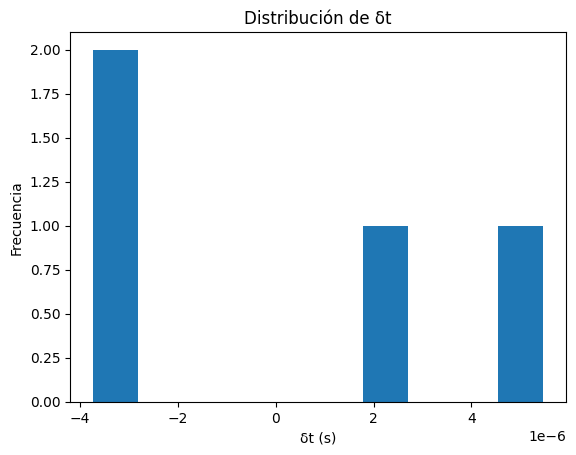

Shapiro-Wilk: estadístico=0.861, p-valor=0.262


NameError: name 'tools' is not defined

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Asumimos que df_out ya existe en el entorno
# 1) Calcular la media global de todos los sampling_median
global_med = df_out['sampling_median'].mean()

# 2) Añadir columnas global_median y delta_t
df_out['global_median'] = global_med
df_out['delta_t'] = df_out['sampling_median'] - global_med

# 3) Ordenar por nombre de fichero (asumiendo orden cronológico lexicográfico)
df_out = df_out.sort_values('file_name').reset_index(drop=True)

# 4) Visualizar evolución de delta_t
plt.figure()
plt.plot(df_out.index, df_out['delta_t'], marker='o')
plt.xlabel('Índice de fichero (orden cronológico)')
plt.ylabel('δt (s)')
plt.title('Evolución de δt respecto a la media global')
plt.grid(True)
plt.show()

# 5) Histograma de δt
plt.figure()
plt.hist(df_out['delta_t'], bins=10)
plt.xlabel('δt (s)')
plt.ylabel('Frecuencia')
plt.title('Distribución de δt')
plt.show()

# 6) Test de normalidad Shapiro-Wilk
stat, p_value = shapiro(df_out['delta_t'].dropna())
print(f"Shapiro-Wilk: estadístico={stat:.3f}, p-valor={p_value:.3f}")

